### Count queries
The most basic statistical tool, a count query, returns an estimate of the number of individual records in the data satisfying a specific predicate. Differentially private answers to count queries
can be obtained through the addition of random noise.

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests, zipfile, io

This notebook explores one disclosure avoidance technique that injects Laplace-distributed noise to tabulated the Public Use Microdata Sample (PUMS) data. First, let's download the PUMS data and read it into a pandas dataframe.

In [5]:
#r = requests.get('https://www2.census.gov/programs-surveys/acs/data/pums/2017/5-Year/csv_ppa.zip')
#z = zipfile.ZipFile(io.BytesIO(r.content))
#z.extract('psam_p22.csv')
#pa = pd.read_csv("psam_p22.csv")

if 'z' not in locals():
    r = requests.get('https://www2.census.gov/programs-surveys/acs/data/pums/2017/5-Year/csv_pla.zip')
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extract('psam_p22.csv')

keepcols = ['PUMA','RACWHT','PINCP','AGEP','SCHL','MIGPUMA','MIGSP','PWGTP']
pa = pd.read_csv("psam_p22.csv", usecols=keepcols)
pa.head()

,PUMA,PWGTP,AGEP,SCHL,MIGPUMA,MIGSP,PINCP,RACWHT
0,900,91,23,19.0,NaN,NaN,20000.0,0
1,900,33,0,NaN,NaN,NaN,NaN,0
2,900,37,7,4.0,NaN,NaN,NaN,0
3,900,67,26,19.0,NaN,NaN,28600.0,0
4,2201,24,41,20.0,NaN,NaN,0.0,1


Next, let's filter the data to contain only relevant variables and geographic area.  
In our example we will focus on migration and age in Louisiana PUMA 2400, which represents New Orleans City (Northeast).   
For variable definitions see:
https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2017.pdf

In [6]:
#Filtering geographic location, race, educational attainment, total income in past 12 months, age and PUMA migrated from
new_pa = pa.query("PUMA==2400").filter(items=['PUMA','RAC1P','RAC2P','SCHL','WAGP','PINCP','AGEP','MIGPUMA','PWGTP'])
new_pa.head()

,PUMA,SCHL,PINCP,AGEP,MIGPUMA,PWGTP
207,2400,18.0,35000.0,30,2390.0,11
208,2400,4.0,NaN,7,NaN,10
275,2400,22.0,68000.0,56,NaN,9
276,2400,20.0,58700.0,57,NaN,14
382,2400,12.0,18000.0,26,NaN,10


First we do a population analysis. We find the weighted population of the PUMA. Since each person in the five-year file is weighted to represent five times as many person-years as people, we multiply by 5. This will generally not be necessary when using internal data. The population of this PUMA over the five years is 718,130. The cumulative population of the smallest state over these five years is 2,913,563. Hence the PUMA fails population analysis.

In [7]:
sum(new_pa['PWGTP'])*5

718130

We make a recode for whether you migrated from a different PUMA and a recode for level of schooling (less than HS grad, HS grad, some college, bachelors degree).

In [8]:
def migrecode(migpuma):
    if pd.isnull(migpuma):
        return 0
    else:
        return 1

def schlrecode_det(schl):
    if schl < 16:
        return 0
    elif schl < 18:
        return 1
    elif schl < 21:
        return 2
    else:
        return 3

new_pa['MIGRATED']=new_pa.MIGPUMA.apply(migrecode)
new_pa['SCHLCAT']=new_pa.SCHL.apply(schlrecode_det)

#create a table showing total count of educational attainment of adults in PA by race. 
pivot_pa = pd.pivot_table(new_pa,
                              index='SCHLCAT',
                              columns='MIGRATED',
                              values='PINCP',
                              aggfunc=np.size,
                              margins=False)

pivot_pa.columns = ['Did not migrate','Migrated']
pivot_pa.rows = ['Less than HS grad','HS grad','Some college','Bachelors']

#TODO: rename columns for clarity.
pivot_pa.head(10)


,Did not migrate,Migrated
SCHLCAT,,
0,2126.0,257.0
1,1370.0,147.0
2,1907.0,202.0
3,2248.0,351.0


**The Laplace Mechanism**
The Laplace mechanism adds Laplace-distributed noise to a function.

Notice that the `laplace_mech()` consumes a parameter `epsilon`. We refer to this quantity as the privacy loss of the mechanism and is part of the most central definition in the field of differential privacy: ε-differential privacy. By tuning epsilon, we control the noisiness of our noisy counting. Choosing a smaller epsilon produces noisier results and better privacy guarantees. 

Generally, the `sensitivity` of a function is the largest possible difference that one row can have on the result of that function, for any dataset. The larger the sensitivity, the noisier the answer will be. Calculating the sensitivity for an arbitrary function can be difficult, but we know that any counting query has a sensitivity of 1, because adding or removing a single row from any dataset will change the count by at most 1.

If S is the sensitivity of a function f, a measure of how revealing the function might be, then adding Laplace noise with scale S/ε preserves ε-differential privacy.

In [9]:
def laplace_mech(mu, epsilon, sensitivity=1.0):
    """Implementation of the Laplace Mechanism that adds Laplace-distributed noise to a function.
  　
    Args:
      mu (float or numpy array): the true answer
      epsilon(int): the privacy budget
      sensitivity (float): the global sensitivity of the query
    """
    eps = epsilon/float(sensitivity)
    scale = 1/eps
    np_shape = np.shape(mu)
    shape = None if np_shape == () else np_shape
    z = np.random.laplace(0.0, scale=scale, size=shape)
    return mu + z

### Quality Metrics

While the trade-off between statistical accuracy and privacy loss is at the heart of differential privacy, there are many metrics for assessing the quality of a published dataset. One approach is to calculate the L1 error between the true data (i.e. without disclosure limitation) and the privatized data.

**The L1 Norm:** In this simple scenario involving the Laplace Mechanism, the L1 error is a natural metric. The L1 norm is basically minimizing the sum of the absolute differences between the target value and the estimated values. This is a somewhat crude measure: a disclosure limited product with a high L1 compared to the same product without disclosure limitation may still be very accurate for its intended use. 

In [10]:
def avg_l1_laplace(epsilon, mu, n=1000):
    """Takes the average error of the laplace mechanism on an array over n samples.
  　
    Args:
      epsilon (int): the privacy budget
      mu (float or numpy array): the true answer
      n (int): number of samples
    """
    total = 0
    for i in range(n):
        noisy_arr = laplace_mech(mu, epsilon, sensitivity=1.0)
        accuracy = 1 - (np.linalg.norm(noisy_arr-mu, 1)/(2*noisy_arr.shape[1]))
        total += accuracy
    return total/n

### Trade-off Between Privacy Loss and Accuracy

When submitting to the DRB, the practitioner prepares a set of graphs that show the trade-off between privacy loss (ε) and accuracy. DRB officials then picks a value of ϵ that allows for sufficient accuracy. Officials most often estimate with epsilon values between 1 and 9.

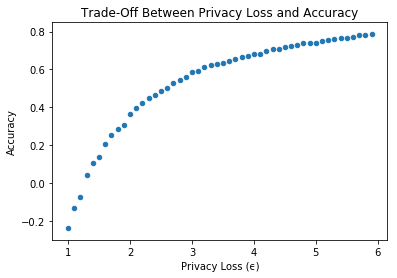

In [11]:
orig_arr = pd.DataFrame(pivot_pa.fillna(0))
accuracy_df = pd.DataFrame()
eps_range = np.arange(1,6.0,.1)
accuracy_df['Privacy Loss (ϵ)'] = eps_range
accuracy_df['Accuracy'] = [avg_l1_laplace(x, orig_arr) for x in eps_range]
accuracy_df.plot.scatter('Privacy Loss (ϵ)', 'Accuracy')
plt.title('Trade-Off Between Privacy Loss and Accuracy')
plt.style.use('seaborn-paper')
plt.savefig('fig.png',facecolor='w', edgecolor='w',
        orientation='portrait', Transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show()

### Postprocessing

We begin by adding noise to the counts, using an epsilon of .25.

In [17]:
noisy_counts = laplace_mech(orig_arr, .25)
noisy_counts

,Did not migrate,Migrated
SCHLCAT,,
0,2123.259469,256.029704
1,1374.631188,142.453166
2,1898.558131,200.156784
3,2263.110069,353.264678


We then round these to the nearest nonzero integer.

In [18]:
def rounder(x):
    if x < 0:
        return 0 
    else:
        return round(x)

In [19]:
#Apply rounder to every cell in new noisy output
rounded_counts = noisy_counts.applymap(rounder)

In [20]:
rounded_counts


,Did not migrate,Migrated
SCHLCAT,,
0,2123,256
1,1375,142
2,1899,200
3,2263,353
